In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from shapkit_nbdev.shapley_values import ShapleyValues
from shapkit_nbdev.inspector import inspector
from shapkit_nbdev.monte_carlo_shapley import MonteCarloShapley
from shapkit_nbdev.sgd_shapley import SGDshapley
from shapkit_nbdev.plots import plot_shapley

from sklearn.ensemble import IsolationForest

# Load dataset

In [2]:
from sklearn.datasets import load_wine

wine = load_wine(return_X_y=False)
X = pd.DataFrame(wine.data, columns=wine.feature_names)
X.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0



# Train a ML model

In [3]:
model = IsolationForest(behaviour="new", contamination="auto")
model.fit(X)

IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

# Define the game

In [4]:
d = X.shape[1]
n = 2**d - 2
d, n

(13, 8190)

## Reward function

def fc(z):
    if model.decision_function(z.reshape(1,-1)) < 0:
        return 1
    else:
        return 0

In [5]:
fc = lambda x: model.decision_function(x.reshape(1,-1))[0]

### Pick an anomaly $x$

In [6]:
idx_anomaly = np.argwhere(model.predict(X) == -1).flatten()
idx_x = np.random.choice(idx_anomaly, size=1)[0]
x = X.iloc[idx_x,:]
x_score = fc(x.values)
print(x)
print()
print("Prediction for x: {0:.2f}".format(x_score))

alcohol                           14.37
malic_acid                         1.95
ash                                2.50
alcalinity_of_ash                 16.80
magnesium                        113.00
total_phenols                      3.85
flavanoids                         3.49
nonflavanoid_phenols               0.24
proanthocyanins                    2.18
color_intensity                    7.80
hue                                0.86
od280/od315_of_diluted_wines       3.45
proline                         1480.00
Name: 3, dtype: float64

Prediction for x: -0.02


### Single reference in normal class

In [7]:
idx_normal = np.argwhere(model.predict(X) == 1).flatten()
idx_r = np.random.choice(idx_normal, size=1)[0]
reference = X.iloc[idx_r,:]
ref_score = fc(reference.values)
print(reference)
print()
print("Prediction for this reference: {0:.2f}".format(ref_score))

alcohol                          13.73
malic_acid                        4.36
ash                               2.26
alcalinity_of_ash                22.50
magnesium                        88.00
total_phenols                     1.28
flavanoids                        0.47
nonflavanoid_phenols              0.52
proanthocyanins                   1.15
color_intensity                   6.62
hue                               0.78
od280/od315_of_diluted_wines      1.75
proline                         520.00
Name: 165, dtype: float64

Prediction for this reference: 0.03


#### Approximation methods

##### Monte Carlo 

In [12]:
mc_shap = MonteCarloShapley(x=x, fc=fc, ref=reference, n_iter=100)
mc_shap

100%|██████████| 100/100 [00:44<00:00,  2.30it/s]


alcohol                        -0.009506
malic_acid                      0.024630
ash                            -0.000640
alcalinity_of_ash               0.003479
magnesium                      -0.004225
total_phenols                  -0.027207
flavanoids                     -0.003296
nonflavanoid_phenols            0.004360
proanthocyanins                -0.006261
color_intensity                -0.008420
hue                             0.002134
od280/od315_of_diluted_wines   -0.015064
proline                        -0.015833
dtype: float64

##### SGD

In [10]:
sgd_est = SGDshapley(d, C=1)
sgd_shap = sgd_est.sgd(x=x, fc=fc, r=reference, n_iter=50, step=.1, step_type="sqrt")
sgd_shap

100%|██████████| 50/50 [00:01<00:00, 25.34it/s]


alcohol                        -0.013659
malic_acid                     -0.003161
ash                             0.000311
alcalinity_of_ash              -0.001530
magnesium                      -0.017229
total_phenols                  -0.005432
flavanoids                     -0.003030
nonflavanoid_phenols            0.017965
proanthocyanins                 0.000260
color_intensity                -0.012896
hue                            -0.002230
od280/od315_of_diluted_wines   -0.014536
proline                        -0.000682
dtype: float64

#### Plot 

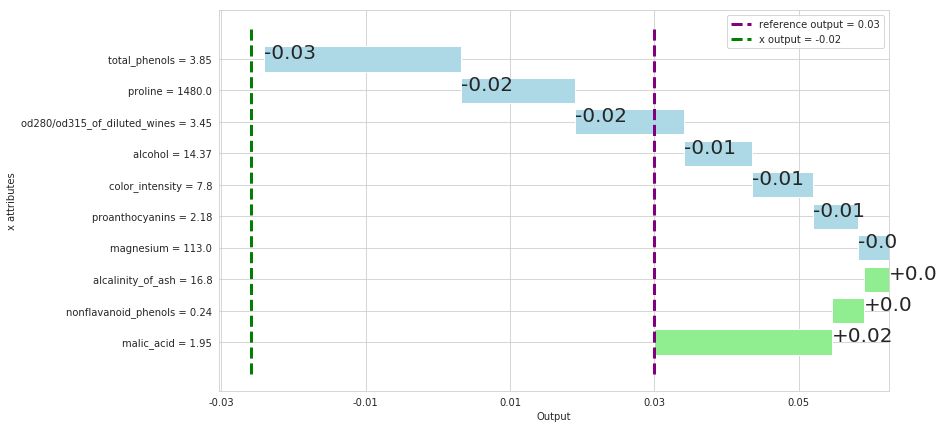

In [15]:
plot_shapley(x=x, fc=fc, ref=reference, shapley_values=mc_shap, n_attributes=10)

### Several references 

In [16]:
n_ref = 10
idx_normal = np.argwhere(model.predict(X) == 1).flatten()
idx_ref = np.random.choice(idx_normal, size=n_ref, replace=False).flatten()
references = X.iloc[idx_ref,:]
references.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
58,13.72,1.43,2.50,16.7,108.0,3.40,3.67,0.19,2.04,6.80,0.89,2.87,1285.0
145,13.16,3.57,2.15,21.0,102.0,1.50,0.55,0.43,1.30,4.00,0.60,1.68,830.0
40,13.56,1.71,2.31,16.2,117.0,3.15,3.29,0.34,2.34,6.13,0.95,3.38,795.0
144,12.25,3.88,2.20,18.5,112.0,1.38,0.78,0.29,1.14,8.21,0.65,2.00,855.0
26,13.39,1.77,2.62,16.1,93.0,2.85,2.94,0.34,1.45,4.80,0.92,3.22,1195.0


#### Approximation methods

##### Monte Carlo 

In [20]:
mc_shaps = MonteCarloShapley(x=x, fc=fc, ref=references, n_iter=100)
mc_shaps

100%|██████████| 100/100 [00:46<00:00,  2.35it/s]


alcohol                        -0.010398
malic_acid                      0.002406
ash                             0.003115
alcalinity_of_ash              -0.000051
magnesium                      -0.001901
total_phenols                  -0.038321
flavanoids                     -0.003594
nonflavanoid_phenols           -0.000895
proanthocyanins                -0.002913
color_intensity                -0.016297
hue                             0.001932
od280/od315_of_diluted_wines   -0.008852
proline                        -0.012335
dtype: float64

#### Plots

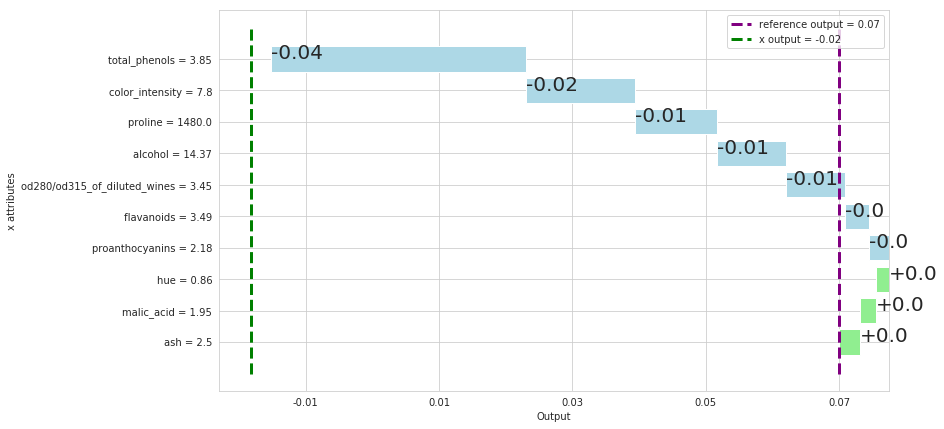

In [21]:
plot_shapley(x=x, fc=fc, ref=references, shapley_values=mc_shaps, n_attributes=10)

# Comparison with several references in the inlier class

In [10]:
n_ref = 10
idx_r = np.random.choice(idx_normal, size=n_ref).flatten()
pool_ref = X.iloc[idx_r,:]
pool_ref.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
155,13.17,5.19,2.32,22.0,93.0,1.74,0.63,0.61,1.55,7.90,0.60,1.48,725.0
89,12.08,1.33,2.30,23.6,70.0,2.20,1.59,0.42,1.38,1.74,1.07,3.21,625.0
92,12.69,1.53,2.26,20.7,80.0,1.38,1.46,0.58,1.62,3.05,0.96,2.06,495.0
104,12.51,1.73,1.98,20.5,85.0,2.20,1.92,0.32,1.48,2.94,1.04,3.57,672.0
79,12.70,3.87,2.40,23.0,101.0,2.83,2.55,0.43,1.95,2.57,1.19,3.13,463.0


In [11]:
x_attributes = [feature + " = " + str(val) for feature, val in x.iteritems()]
pool_shapley = pd.DataFrame(np.zeros((n_ref, d)), columns=x_attributes)
for i in range(n_ref): 
    mc_shap = MonteCarloShapley(x=x, fc=fc, r=r, n_iter=5)
    pool_shapley.iloc[i,:] = mc_shap.values

In [12]:
mean_pool_shap = pool_shapley.mean(axis=0)
mean_pool_shap

alcohol = 12.79                       -0.14
malic_acid = 2.67                      0.02
ash = 2.48                             0.00
alcalinity_of_ash = 22.0              -0.04
magnesium = 112.0                      0.18
total_phenols = 1.48                   0.18
flavanoids = 1.36                      0.00
nonflavanoid_phenols = 0.24            0.02
proanthocyanins = 1.26                 0.10
color_intensity = 10.8                 0.46
hue = 0.48                             0.34
od280/od315_of_diluted_wines = 1.47    0.02
proline = 480.0                       -0.14
dtype: float64

In [13]:
np.sum(mean_pool_shap)

1.0000000000000002

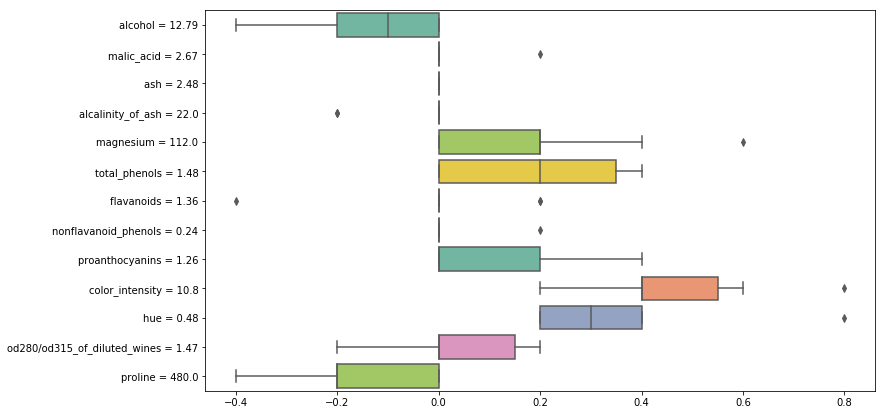

In [14]:
plt.figure(figsize=(12,7))
ax = sns.boxplot(data=pool_shapley, orient="h", palette="Set2")
plt.show()